In [1]:
# The numerical integrators are located in a module two levels above
# the current working directory. Hence:
import sys
sys.path.insert(0, '../..')

In [5]:
# Importing required packages:

# Numpy
import numpy as np

# Matplotlib
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
%matplotlib inline

# Numba (JiT)
from numba import jit

# (Primitive) timing functionality
import time 

# Multiprocessing:
import multiprocessing as mp

# Spline interpolation:
from scipy.interpolate import RectBivariateSpline

# Check whether folders exist or not, necessary
# for storing advected states:
import os
import errno

In [94]:
# Function that makes a directory if it does not exist,
# and raises an exception otherwise 
# (necessary for storing advected states)

def ensure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [7]:
# Domain of the velocity field:
x_min, x_max = 0., 2.
y_min, y_max = 0., 1.

# Domain lengths in either direction
x_len, y_len = x_max - x_min, y_max - y_min

In [31]:
# Defining the velocity field:

@jit(nopython=True)
def _doublegyre(t,x,A,e,w):
    # a(t)
    a = e * np.sin(w*t)       
    # b(t)
    b = 1 - 2*e*np.sin(w*t)  
    # f(x,t)
    f = a*x[0,:]**2 + b*x[0,:]
    # df/dx
    dfdx = 2*a*x[0,:] + b
    
    v = np.empty(x.shape)                         
    # x-component:
    v[0,:] = -np.pi*A*np.sin(np.pi*f)*np.cos(np.pi*x[1,:])
    # y-component:
    v[1,:] = np.pi*A*np.cos(np.pi*f)*np.sin(np.pi*x[1,:])*dfdx
    return v 

@jit(nopython=True)
def doublegyre_wrapper(t,x):
    # Parameters of the velocity field (Cf. Farazmand & Haller, 2012)
    # A
    A = 0.1
    # epsilon
    e = 0.1
    # omega
    w = 2*np.pi/10
    return _doublegyre(t,x,A,e,w)

In [74]:
# Function returning a grid of particles meant for plotting etc.
def grid_of_particles(Nx,Ny=None):
    if Ny is None:
        Ny = np.round(Nx*y_len/x_len).astype(int)
    
    dx = x_len/Nx
    dy = y_len/Ny
    
    x0 = (np.arange(Nx)+1./2.)*dx
    y0 = (np.arange(Ny)+1./2.)*dy
    
    y, x = np.meshgrid(y0,x0)
    
    return np.array([x,y])

# Function returning a flattened grid of particles, meant for
# advection, and only supposed to be used by
# other functions (i.e., not called directly by the user)
def _grid_of_particles_for_transport(grid):
    Nx = np.shape(grid)[1]
    Ny = np.shape(grid)[2]
    
    _grid = np.empty((2,Nx*Ny))
    
    x0 = grid[0][:,0]
    y0 = grid[1][0]
    
    for j in range(Nx):
        _grid[0,j*Ny:(j+1)*Ny] = x0[j]
        _grid[1,j*Ny:(j+1)*Ny] = y0
        
    return _grid

In [41]:
# String set containing the names of the implemented
# fixed stepsize integrators:
fixed_stepsize_integrators = set(['euler', 'rk2', 'rk3', 'rk4'])

In [86]:
# Functions advecting particles with positions defined by meshgrids [X,Y]

def endpoints(t_curr,t_end,pos_curr,h,integrator,deriv,n_proc=4,atol=None,rtol=None):
    # Flatten input meshgrids for efficiency:
    Nx = np.shape(pos_curr)[1]
    Ny = np.shape(pos_curr)[2]
    pos_curr = _grid_of_particles_for_transport(pos_curr)
    partition = np.floor(np.size(pos_curr,1)/n_proc).astype(int)
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    if integrator.__name__ in fixed_stepsize_integrators:
        processlist = [mp.Process(target = _endpoints_fixed_slice,
                             args=(t_curr,t_end,
                                  pos_curr[:,j*partition:np.size(pos_curr,1) if j+1 is n_proc else (j+1)*partition],
                                  h,integrator,deriv,queuelist[j])) for j in range(n_proc)]
    else:
        processlist = [mp.Process(target = _endpoints_fixed_slice,
                             args=(t_curr,t_end,
                                  pos_curr[:,j*partition:np.size(pos_curr,1) if j+1 is n_proc else (j+1)*partition],
                                  h,integrator,deriv,atol,rtol,queuelist[j])) for j in range(n_proc)]
    
    for process in processlist:
        process.start()
    for j, queue in enumerate(queuelist):
        pos_curr[:,j*partition:np.size(pos_curr,1) if j+1 is n_proc else (j+1)*partition] = queue.get()
    for process in processlist:
        process.join()
        
    return pos_curr.reshape((2,Ny,Nx))
    
def _endpoints_fixed_slice(t_curr,t_end,pos_curr,h,integrator,deriv,q):
    t = t_curr
    while(t < t_end):
        h = np.minimum(h,t_end-t)
        t, pos_curr, h = integrator(t,pos_curr,h,deriv)
    q.put(pos_curr)
    
def _endpoints_adaptive_slice(t_curr,t_end,pos_curr,h,integrator,deriv,atol,rtol,q):
    h = np.ones(np.size(pos_curr,1))*h
    t = np.ones(np.size(pos_curr,1))*t_curr
    while(np.any(t < t_end)):
        h = np.minimum(h,t_end-t)
        t, pos_curr, h = integrator(t,pos_curr,h,deriv,atol,rtol)
    q.put(pos_curr)       

# Step 0: Check that the advection works (as expected)

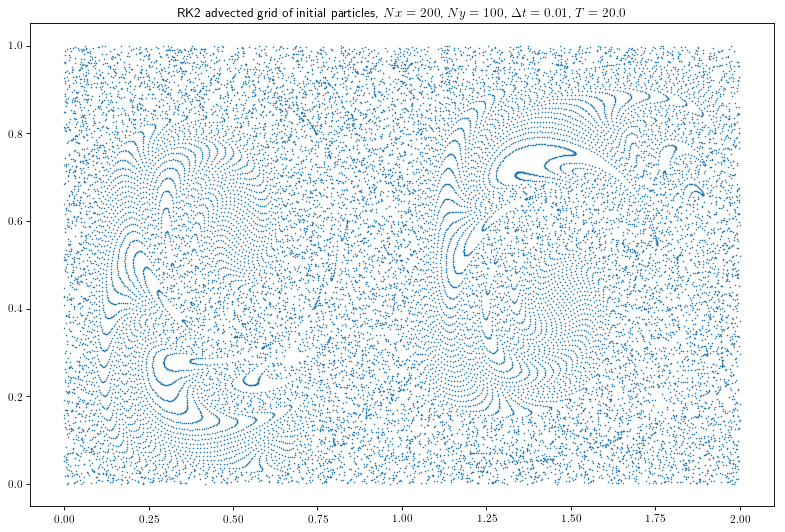

In [85]:
from numerical_integrators.singlestep import rk2
Nx = 200
Ny = 100

pos_init = grid_of_particles(Nx,Ny)

t_curr = 0.
t_max = 20.
dt = 0.01

pos_end = endpoints(t_curr,t_max,pos_init,h=dt,integrator=rk2,deriv=doublegyre_wrapper)

plt.figure(figsize=(12,8),dpi=80)
plt.scatter(pos_end[0],pos_end[1],s=2,lw=0)
plt.title(r'RK2 advected grid of initial particles, $Nx={}$, $Ny={}$, $\Delta t={}$, $T={}$'.format(Nx,Ny,dt,t_max))

# Step 1: Define functions which return eigenvalues and -vectors of strain tensors (i.e., characteristics)

In [116]:
# Function that takes the initial time, end time, integration step
# and initial positions (meshgrids) as inputs, returning
# the computed eigenvalues and eigenvectors of the strain tensors
# at the end time
def characteristics(t_curr,t_end,pos_curr,h,integrator,rhs,n_proc=4,atol=1.e-6,rtol=1.e-9):
    # If the advection has already been performed previously, load saved state
    
    # For fixed step integrators, the tolerance plays no role, and its value is thus not
    # stored in the file names; similarly, the (initial) step length plays no _real_
    # role for adaptive step size integrators, and is thus not stored in file names.
    
    dx = pos_curr[0,1,0]-pos_curr[0,0,0]
    dy = pos_curr[1,0,1]-pos_curr[1,0,0]
    
    deltax = np.minimum(1e-5,dx*1e-2)
    deltay = np.minimum(1e-5,dy*1e-2)
    
    try: 
        if integrator.__name__ in fixed_stepsize_integrators:
            lambda1 = np.load('precomputed_characteristics/{}/lambda1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h))
            lambda2 = np.load('precomputed_characteristics/{}/lambda2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h))
            xi1 = np.load('precomputed_characteristics/{}/xi1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h))
            xi2 = np.load('precomputed_characteristics/{}/xi2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h))
        else:
            lambda1 = np.load('precomputed_characteristics/{}/lambda1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol))
            lambda2 = np.load('precomputed_characteristics/{}/lambda2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol.rtol))
            xi1 = np.load('precomputed_characteristics/{}/xi1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol))
            xi2 = np.load('precomputed_characteristics/{}/xi2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol))
        print('Precomputed characteristics found! Advection not necessary in this case.')
    except IOError:
        tic = time.time()
        print('Precomputed characteristics not found! Please wait!')
        lambda1, lambda2, xi1, xi2 = _characteristics(t_curr,t_end,pos_curr,h,integrator,rhs,dx,dy,deltax,deltay,n_proc,atol,rtol)

        toc = time.time()
        
        print('Advection etc. was necessary, time elapsed: {} seconds'.format(toc-tic))
        
        if integrator.__name__ in fixed_stepsize_integrators:
            np.save('precomputed_characteristics/{}/lambda1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h), lambda1)
            np.save('precomputed_characteristics/{}/lambda2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h), lambda2)
            np.save('precomputed_characteristics/{}/xi1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h), xi1)
            np.save('precomputed_characteristics/{}/xi2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_h={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,h), xi2)
            
        else:
            np.save('precomputed_characteristics/{}/lambda1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol), lambda1)
            np.save('precomputed_characteristics/{}/lambda2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol), lambda2)
            np.save('precomputed_characteristics/{}/xi1_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol), xi1)
            np.save('precomputed_characteristics/{}/xi2_Nx={}_Ny={}_dx={}_dy={}_deltax={}_deltay={}_t_curr={}_t_end={}_atol={}_rtol={}.npy'.format(
                                    integrator.__name__,np.shape(pos_curr)[1],np.shape(pos_curr)[2],dx,dy,deltax,deltay,t_curr,t_end,atol,rtol), xi2)
        
        print('Characteristics now stored. Advection will not be necessary the next time the same parameters are used!')
        
        return lambda1, lambda2, xi1, xi2
        
def _characteristics(t_curr,t_end,pos_curr,h,integrator,rhs,dx,dy,deltax,deltay,n_proc,atol,rtol):
    # Advect main and auxiliary grid points:
    grid_end = _endpoints_grid(t_curr,t_end,np.array([_grid_of_particles_for_transport(pos_curr),
                                                        _grid_of_particles_for_transport(pos_curr)+np.array([deltax,0]).reshape(2,1),
                                                        _grid_of_particles_for_transport(pos_curr)+np.array([0,deltay]).reshape(2,1),
                                                        _grid_of_particles_for_transport(pos_curr)+np.array([-deltax,0]).reshape(2,1),
                                                        _grid_of_particles_for_transport(pos_curr)+np.array([0,-deltay]).reshape(2,1)]),
                                h,integrator,rhs,n_proc,atol,rtol)
    pos_main = grid_end[0,:,:].reshape(np.shape(pos_curr))
    pos_right = grid_end[1,:,:].reshape(np.shape(pos_curr))
    pos_top = grid_end[2,:,:].reshape(np.shape(pos_curr))
    pos_left = grid_end[3,:,:].reshape(np.shape(pos_curr))
    pos_beneath = grid_end[4,:,:].reshape(np.shape(pos_curr))
    
    main_tensor, auxiliary_tensor = _find_strain_tensors(pos_main,pos_right,pos_top,pos_left,pos_beneath,dx,dy,deltax,deltay)
    
    lambda1, lambda2, xi1, xi2 = _find_characteristics(main_tensor,auxiliary_tensor)
    
    return lambda1, lambda2, xi1, xi2

def _endpoints_grid(t_curr,t_end,pos_curr,h,integrator,rhs,n_proc,atol,rtol):
    partition = np.floor(np.size(pos_curr,2)/n_proc).astype(int)
    queuelist = [mp.Queue() for j in range(n_proc)]
    if integrator.__name__ in fixed_stepsize_integrators:
        processlist = [mp.Process(target=_endpoints_grid_fixed_slice,
                                 args=(t_curr,t_end,
                                      pos_curr[:,:,j*partition:np.size(pos_curr,2) if j+1 is n_proc else (j+1)*partition],
                                      h,integrator,rhs,queuelist[j])) for j in range(n_proc)]
    else:
        processlist = [mp.Process(target=_endpoints_adaptive_slice,
                                 args=(t_curr,t_end,
                                      pos_curr[:,:,j*partition:np.size(pos_curr,2) if j+1 is n_proc else (j+1)*partition],
                                      h,integrator,rhs,atol,rtol,queuelist[j])) for j in range(n_proc)]
        
    for process in processlist:
        process.start()
    for j, queue in enumerate(queuelist):
        pos_curr[:,:,j*partition:np.size(pos_curr,2) if j+1 is n_proc else (j+1)*partition] = queue.get()
    for process in processlist:
        process.join()
    
    return pos_curr

def _endpoints_grid_fixed_slice(t_curr,t_end,pos_curr,h,integrator,rhs,q):
    for j in range(5):
        stride = np.copy(h)
        t = np.copy(t_curr)
        while (t<t_end):
            stride = np.minimum(stride,t_end-t)
            t,pos_curr[j,:,:],stride = integrator(t,pos_curr[j,:,:],stride,rhs)        
    q.put(pos_curr)
    
def _endpoints_grid_adaptive_slice(t_curr,t_end,pos_curr,h,integrator,rhs,atol,rtol,q):
    for j in range(5):
        stride = np.ones(np.size(pos_curr,2))*h
        t = np.ones(np.size(pos_curr,2))*t_curr
        while (np.any(t<t_end)):
            stride = np.minimum(stride,t_end-t)
            t,pos_curr[j,:,:],stride = integrator(t,pos_curr[j,:,:],stride,rhs,atol=atol,rtol=rtol)        
    q.put(pos_curr)
    
def _find_strain_tensors(pos_main,pos_right,pos_above,pos_left,pos_beneath,dx,dy,deltax,deltay):
    # Find Jacobian of auxiliary grid:
    dF_a = np.empty((2,2,np.size(pos_main,1),np.size(pos_main,2)))
    
    # Centered differencing throughout:
    # dx/dx
    dF_a[0,0,:,:] = (pos_right[0]-pos_left[0])/(2*deltax)
    # dx/dy
    dF_a[0,1,:,:] = (pos_above[0]-pos_beneath[0])/(2*deltay)
    # dy/dx
    dF_a[1,0,:,:] = (pos_right[1]-pos_left[1])/(2*deltax)
    # dy/dy
    dF_a[1,1,:,:] = (pos_above[1]-pos_beneath[1])/(2*deltay)
    
    # Find Jacobian of main grid:
    dF = np.empty(np.shape(dF_a))
    
    # dx/dx
    # Centered differences for the interior points:
    dF[0,0,1:-1,:] = (pos_main[0,2:,:]-pos_main[0,0:-2,:])/(2*dx)
    # Second order accurate forwards / backwards difference for the edges:
    dF[0,0,0,:]  = (-3*pos_main[0,0,:]+4*pos_main[0,1,:]-2*pos_main[0,2,:])/(2*dx)
    dF[0,0,-1,:] = (3*pos_main[0,-1,:]-4*pos_main[0,-2,:]+2*pos_main[0,-3,:])/(2*dx)
    
    # dx/dy
    # Centered differences for the interior points:
    dF[0,1,:,1:-1] = (pos_main[0,:,2:]-pos_main[0,:,0:-2])/(2*dy) 
    # Second order accurate forwards / backwards difference for the edges:
    dF[0,1,:,0]  = (-3*pos_main[0,:,0]+4*pos_main[0,:,1]-2*pos_main[0,:,2])/(2*dy)
    dF[0,1,:,-1] = (3*pos_main[0,:,-1]-4*pos_main[0,:,-2]+2*pos_main[0,:,-3])/(2*dy)
    
    # dy/dx
    # Centered differences for the interior points:
    dF[1,0,1:-1,:] = (pos_main[1,2:,:]-pos_main[1,0:-2,:])/(2*dx)
    # Second order accurate forwards / backwards difference for the edges:
    dF[1,0,0,:]  = (-3*pos_main[1,0,:]+4*pos_main[1,1,:]-2*pos_main[1,2,:])/(2*dx) 
    dF[1,0,-1,:] = (3*pos_main[1,-1,:]-4*pos_main[1,-2,:]+2*pos_main[1,-3,:])/(2*dx)
    
    # dy/dy
    # Centered differences for the interior points:
    dF[1,1,:,1:-1] = (pos_main[1,:,2:]-pos_main[1,:,0:-2])/(2*dy)  
    # Second order accurate forwards / backwards difference for the edges:
    dF[1,1,:,0]  = (-3*pos_main[1,:,0]+4*pos_main[1,:,1]-2*pos_main[1,:,2])/(2*dy)
    dF[1,1,:,-1] = (3*pos_main[1,:,-1]-4*pos_main[1,:,-2]+2*pos_main[1,:,-3])/(2*dy)
    
    # Allocate the strain tensors:
    C = np.empty(np.shape(dF))
    C_a = np.empty(np.shape(dF_a))
    
    # Explicitly calculate the strain tensors:
    for i in range(dF.shape[2]):
        for j in range(dF.shape[3]):
            C[:,:,i,j] = np.dot(dF[:,:,i,j].T,dF[:,:,i,j])
            C_a[:,:,i,j] = np.dot(dF_a[:,:,i,j].T,dF_a[:,:,i,j])
            
    return C, C_a

def _find_characteristics(main_tensor,auxiliary_tensor):
    lambda1 = np.empty((main_tensor.shape[2],main_tensor.shape[3]))
    lambda2 = np.empty(lambda1.shape)
    xi1 = np.empty((2,lambda1.shape[0],lambda1.shape[1]))
    xi2 = np.empty(xi1.shape)
    
    for i in range(lambda1.shape[0]):
        for j in range(lambda1.shape[1]):
            values, vectors = np.linalg.eigh(main_tensor[:,:,i,j])
            values_a, vectors_a = np.linalg.eigh(auxiliary_tensor[:,:,i,j])
            
            lambda1[i,j] = values[0]
            lambda2[i,j] = values[1]
            
            xi1[:,i,j] = vectors_a[:,0]
            xi2[:,i,j] = vectors_a[:,1]
            
    return lambda1, lambda2, xi1, xi2
    
    
    

# Step 2: Define grid cells, time step, simulation time and integrator

## Then, calculate the eigenvectors and -values

In [117]:
from numerical_integrators.singlestep import rk4

integrator = rk4

# Create output directory for precomputed characteristics, if it does not already exist:
ensure_path_exists('precomputed_characteristics/{}'.format(integrator.__name__))

Nx = 200
Ny = 100

t_min = 0.
t_max = 20.
dt = 0.01

pos_init = grid_of_particles(Nx,Ny)

lambda1, lambda2, xi1, xi2 = characteristics(t_min,t_max,pos_init,dt,integrator,doublegyre_wrapper)


Precomputed characteristics not found! Please wait!
Advection etc. was necessary, time elapsed: 104.62862086296082 seconds
Characteristics now stored. Advection will not be necessary the next time the same parameters are used!


(0, 1)

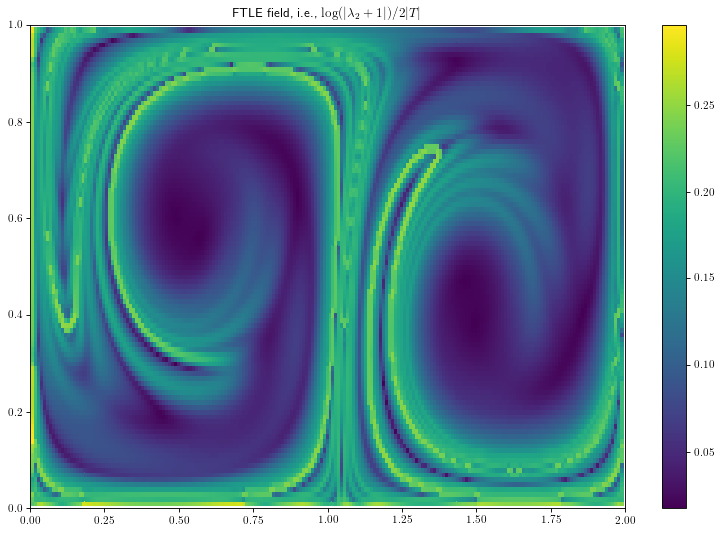

In [119]:
plt.figure(figsize=(12,8),dpi=80)
plt.pcolormesh(pos_init[0], pos_init[1], np.log(np.abs(lambda2)+1)/(2*np.abs(t_max)))
plt.colorbar()
plt.title(r'FTLE field, i.e., $\log(|\lambda_{2} + 1|) / 2|T|$')
plt.xlim(0,2)
plt.ylim(0,1)